# Gaussian Process Example

In [1]:
# ignore this cell, just for ZD to get necessary paths
import sys
paths = ['', '/Users/Zoheyr/opt/lalsuite/lib/python2.7/site-packages', '/Users/Zoheyr/src/lalsuite', '/Users/Zoheyr/anaconda/lib/python27.zip', '/Users/Zoheyr/anaconda/lib/python2.7', '/Users/Zoheyr/anaconda/lib/python2.7/plat-darwin', '/Users/Zoheyr/anaconda/lib/python2.7/plat-mac', '/Users/Zoheyr/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/Zoheyr/anaconda/lib/python2.7/lib-tk', '/Users/Zoheyr/anaconda/lib/python2.7/lib-old', '/Users/Zoheyr/anaconda/lib/python2.7/lib-dynload', '/Users/Zoheyr/.local/lib/python2.7/site-packages', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-macosx-10.5-x86_64.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/setuptools-18.4-py2.7.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/aeosa', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/Zoheyr', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/Zoheyr/Library/Python/2.7/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gst-0.10', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gtk-2.0', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/', '/Users/Zoheyr/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap']
for p in paths:
    if p not in sys.path:
        sys.path.append(p)
    else:
        pass


In [178]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.linalg as spl
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import emcee as mc

## Regression with Gaussian Processes

In the examples presented thus far, samples have been generated from some covariance matrix that describes the full joint distribution on function values.  In Gaussian process regression, one is interested in _conditional_ distributions of function values.  We seek to infer possible function values conditioned on a few known values of the function. We can write the joint probability distribution of function values ${\bf f}_*$ at points $X_*$ and ${\bf f}$ at points $X$ as:

$$p([{\bf f}, {\bf f}_*]) = \frac{1}{(2\pi)^{n/2}|K|^{1/2}}\exp\left(-\frac{1}{2}[{\bf f}, {\bf f}_*]^\top K^{-1}[{\bf f}, {\bf f}_*]\right) \hspace{2cm} \textrm{(4.1)}$$

Let's define:
$$\Gamma = K^{-1} = 
\begin{pmatrix} 
\Gamma_{XX} & \Gamma_{XX_*}  \\ 
\Gamma_{XX_*} & \Gamma_{X_*X_*}  \\
\end{pmatrix}, 
K=
\begin{pmatrix} 
K_{XX} & K_{XX_*}  \\ 
K_{X_*X} & K_{X_*X_*}  \\
\end{pmatrix}$$

If we condition on known ${\bf f}$, then all terms with only ${\bf f}$'s become constants and can be ignored:

$$
\begin{align}
p({\bf f}_*|{\bf f}) & \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\Gamma_{X_*X_*}{\bf f_*} - {\bf f}^\top\Gamma_{XX_*}{\bf f_*}\right) \hspace{2cm} \textrm{(4.2)}\\
& 
\end{align}
$$ 

The relations between the submatrices of $\Gamma$ and $K$ are:

$$\Gamma_{XX_*} = -K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$
$$\Gamma_{X_*X_*} = \left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$

The $K$ matrices are the covariances between test and/or input values of $f(x)$.  Substituting those into Equation (4.2) yields:

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}{\bf f_*} - {\bf f}^\top\left(-K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}\right){\bf f_*}\right)$$

We can complete the square by adding this term in the exponential:

$$-\frac{1}{2}{\bf f}^\top\left(K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}K_{X_*X}K_{XX}^{-1}\right){\bf f}$$

Notice that this term is independent of ${\bf f}_*$, so adding it in the exponential only affects the normalization.  After completing the square, we get 

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})\right)$$

We see that this is now a multivariate Gaussian with mean $K_{X_*X}K_{XX}^{-1}{\bf f}$ and covariance $K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This result is the workhorse of Gaussian process regression, and we summarize it here:

$$ p({\bf f}_*|{\bf f}) \sim \mathcal{N}\left(K_{X_*X}K_{XX}^{-1}{\bf f}, \hspace{0.2cm} K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right) \hspace{2cm} \textrm{(4.3)}$$

Let's take a second to digest this equation.  First, we can see that the mean values of ${\bf f}_*$ are generated by a linear transformation of the input values ${\bf f}$. Second, the variance of the conditional distribution is independent of ${\bf f}$ -- it only depends on the $K$ matrices, which are constructed only from $X$, $X_*$ and the kernel.  Therefore, local behavior of the values of ${\bf f}$ does not affect the predicted conditional variances. Also note that the first term of the conditional covariance is simply the prior covariance $K_{X_*X_*}$ and from it is subtracted $K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This second term is large when values of $K_{X_*X}$ and $K_{XX_*}$ are large and/or $K_{XX}$ values are small. Thus if a kernel such as the squared-exponential is used, where the covariance falls off with the distance between parameter values, ${\bf f}_*$ will be distributed like the prior if $X_*$ are "far away" from $X$ since the second term will go to zero.   

## Computing a GPR

Now that we have Equation 4.3, let's perform some regression!  To do this, we'll need to choose a covariance function and we'll require a bit more machinery in terms of practically performing the matrix operations required on a computer. 
### Squared-Exponential Kernel
The Gaussian process regression depends crucially on the kernel function, which encodes the covariance between values of our function of interest. The kernel function is used directly to compute values of the $K$ submatrices presented above.  Let's start with the most basic kernel, the squared exponential, which has the form:

$$k(x,x') = \exp\left(-\frac{1}{2}\frac{||x-x'||^2}{l^2}\right)$$

We can write a more flexible version too (Einstein summation convention used):

$$k(x,x') = \exp\left(-\frac{1}{2}g_{ab}x_ax_b\right)$$

$l$ or the components of $g_{ab}$ are chosen by the user or can be optimized for.  Below, we've defined a squared exponential kernel method that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$.

In [237]:
def squared_exponential_kernel(X1,X2,scale=1.0,metric=None):
    """
    Computes the square exponential kernel.
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale=(1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            K[i,j] = np.exp(-0.5*dist(X1[i,:],X2[j,:])**2)
    return K
            

In the cell below, plot samples from the prior.  Try changing the scale and nugget values and see what happens.  The "nugget" is just a set of values added to the diagonal of the covariance matrix to ensure numerical stability and to account for variance in the training data.  

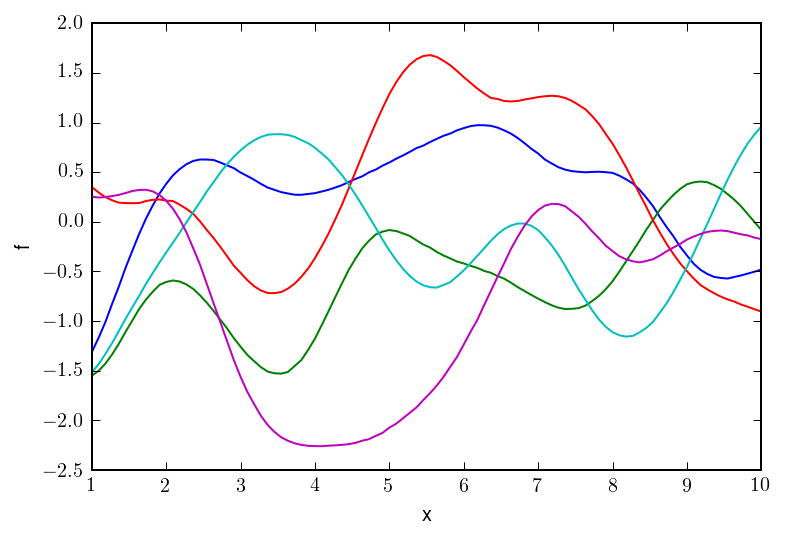

In [238]:
X = np.linspace(1,10,100).reshape(-1,1)
length_scale = 1.0
cov_scale = 1.0
K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
nugget_val = 1e-5
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
for i in range(5):
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K+nugget)
    plt.plot(X,f)
plt.xlabel('x')
plt.ylabel('f')

### Investigations:
1. How does the morphology of the GP samples change as you vary the length scale?
2. For the overall covariance scale?
3. What happens when the nugget is made very small?

### An Exercise:
Define an analogous K-matrix generator method for the Matern 3/2 kernel, and make the same plot as above.  

### Conditioning
Now let's condition the GP we created with our squared-exponential kernel.  To do this, we need to take the inverse of $K_{XX}$.  We will effectively do this via the Cholesky decomposition, which decomposes a matrix $K$ as $K=LL^\top$, where $L$ and $L^\top$ are lower and upper triangular matrices, respectively. Rather than directly find the inverse of $K$, we can solve for the vector ${\bf x}$ which fulfills the equation:
$$ {\bf y} = K{\bf x} = LL^\top{\bf x}$$
We write the solution as ${\bf x} = K\setminus {\bf y}$.  Substituting in the triangular matrices, we have ${\bf x} = L^\top\setminus (L \setminus {\bf y})$.  To solve for ${\bf b} = L \setminus {\bf y}$, use forward substitution and for $x = L^\top\setminus {\bf b}$ use backward substitution. With this inversion scheme in hand, we can write the numerical procedure algorithmically as (following Rasmussen and Williams Algorithm 2.1):

1. $L := {\rm Cholesky}(K)$
2. ${\bf \alpha} := L^\top \setminus (L \setminus {\bf f})$
3. ${\bf \bar{f}_*} := {\bf k}_*^\top {\bf \alpha}$
4. ${\bf v} := L \setminus {\bf k}_*$
5. $\mathbb{V} := {\bf k}_* - {\bf v}^\top {\bf v}$
6. $\log p({\bf f}|X) := -\frac{1}{2}{\bf f }^\top {\bf \alpha} - \sum_i L_{ii} - \frac{n}{2}\log(2\pi)$

Here, ${\bf k}_*:= k({\bf x_*},X)$ is the kernel function $k$ evaluated at the test point ${\bf x_*}$ and the set of input points $X$. If one is only interested in the mean ${\bf \bar{f}_*}$, then one only need save out ${\bf \alpha}$ as the trained interpolator.  If variances are desired (which is typically the point of using GPR), $L$ must also be saved.  Line 6 of the algorithm computes the log marginal likelihood of values ${\bf f}$ under the Gaussian process prior -- it will come in handy later.  In the cell below, we follow the algorithm above to condition a GP on a few known values of the sine function.  

The log likelihood is -7.30220174126


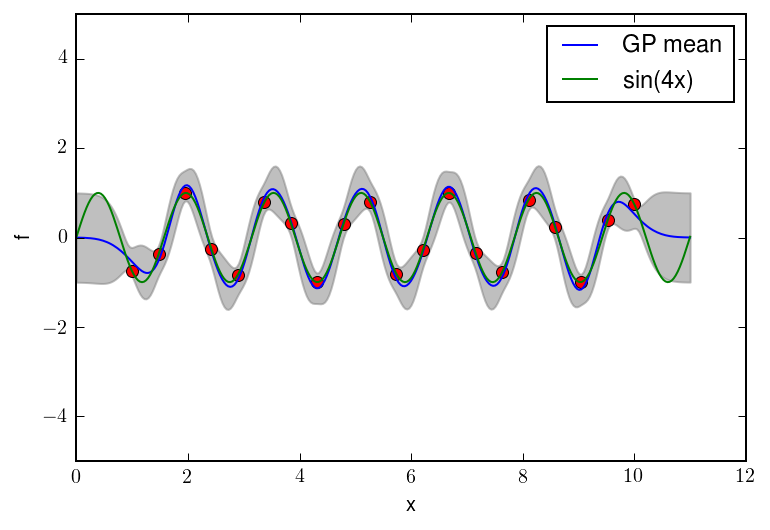

In [236]:
# The training points and training values
X = np.linspace(1,10,20).reshape(-1,1)
f = np.sin(4.*X)

# The test points and real values of f at test points
Xstar = np.linspace(0,11,300).reshape(-1,1)
fstar = np.sin(4.*Xstar)

# Choose a kernel, nugget, and compute covariance matrices
length_scale = 0.1
KXX = squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)
nugget_val = 5e-2
nugget = np.diag(nugget_val*np.ones(X.shape[0]))

# Steps 1-2
L = spl.cholesky(KXX+nugget,lower=True)
alpha = spl.cho_solve((L.T,False),spl.cho_solve((L,True), f))

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.cho_solve((L,True),KXXstar[i,:])
    variances.append(1.-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

plt.plot(X,y,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar,fstar_bar=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar,fstar_bar-stds,fstar_bar+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()

## Choosing the Kernel and Hyperparameters:
The kernel and it's associated hyperparameters are the bedrock of the Gaussian process regression and determine the overall morphology of the interpolations.  In most cases of interpolating smooth functions, the squared-exponential will suffice, and in simple cases one can even hand tune the hyperparameters.  In the machine-learning context though, one is more interested in fitting the hyperparameters to maximize some objective function of the observed data.  The squared-exponential kernel may not be right for all cases, either, as we shall see.  

The most natural objective function for deciding on kernel and/or hyperparameter choice is the log marginal likelihood. Let's perform the same interpolation as above but choose hyperparameters that maximize this.  One can also optionally introduce a "hyperprior", ie. a prior distribution on hyperparameter values. This can be helpful if the marginal likelihood is not well behaved or has many local minima.

In [456]:
np.seterr(divide='raise',under='warn',over='raise')
def log_marginal_likelihood(theta,X,f):
    """
    Compute the log_marginal_likelihood of data f
    at points X under GP given by covariance K
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    
    Returns
    -------
    lml: float
        log marginal likelihood of data f
    """
    if np.any(np.absolute(theta)> 3.):
        return -1e500
    cov_scale = 10.**theta[0]
    length_scale = 10.**theta[1]
    try:
        K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
        nugget = np.diag((10.**theta[2])*np.ones(X.shape[0]))
        #nugget = np.diag(nugget_val*np.ones(X.shape[0]))
        L = spl.cholesky(K+nugget,lower=True)
        alpha = spl.cho_solve((L.T,False),spl.cho_solve((L,True), f))
        lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
        lml = lml.flatten()[0]
    except:
        return -1e500
    return lml

from scipy.stats import norm
def log_hyperprior(theta,theta_means,theta_widths):
    """
    The log hyperprior
    
    Parameters
    ----------
    theta: array
        array of parameter values
    theta_means: array
        array of mean values of lognormal prior
    theta_widths:
        widths of lognormal prior
    
    Returns
    -------
    log_h: float
        log hyperprior
    """
    log_h = 0.
    for i in range(len(theta)):
        log_h = log_h + np.log(norm.pdf(theta[i], theta_means[i], theta_widths[i]))
    return log_h

def log_hyperposterior(theta,X,f,theta_means,theta_widths):
    """
    The log hyperposterior
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    theta_means: array
        array of mean values of lognormal prior
    theta_widths:
        widths of lognormal prior
        
    Returns
    -------
    log_hyperposterior: float
        the log hyperposterior
    """
    return log_marginal_likelihood(theta,X,f)+log_hyperprior(theta,theta_means,theta_widths)

To begin with, we'll do a brute-force optimization by pulling a bunch of parameter values from the hyperprior and then checking the hyperposterior values to find the maximum.  

In [463]:
# The training points and training values
X = np.linspace(1,10,30).reshape(-1,1)
f = np.sin(4.*X)

theta_means = [0.,-1.,-1]
theta_widths= [1.,1.,1.]
ntries = 500
loghps = []
thetas = []
for j in range(ntries):
    theta = [] 
    for i in range(len(theta_means)):
        theta.append(np.random.normal(theta_means[i], theta_widths[i]))
    loghps.append(log_hyperposterior(theta,X,f,theta_means,theta_widths))
    thetas.append(theta)
loghps=np.array(loghps)
thetas=np.array(thetas)

theta = thetas[np.argwhere(loghps==np.amax(loghps))][0][0]
print theta

/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: underflow encountered in multiply


[ 0.15428381 -0.75518257 -1.63293198]


1.42653951649 0.175718475895 0.0232845593689
The log likelihood is 3.56359500469


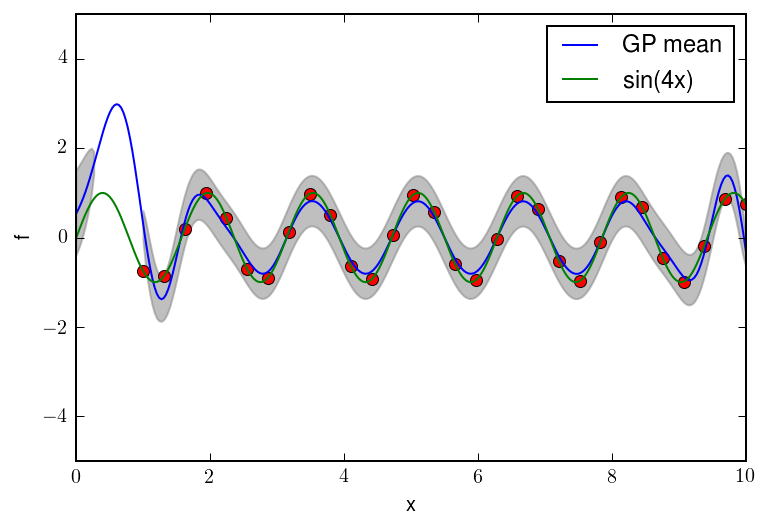

In [464]:

# The test points and real values of f at test points
Xstar = np.linspace(0,10,300).reshape(-1,1)
fstar = np.sin(4.*Xstar)

# Choose a kernel, nugget, and compute covariance matrices

cov_scale = 10.**theta[0]
length_scale = 10.**theta[1]
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)
nugget_val = 10**theta[2]
print cov_scale,length_scale,nugget_val
nugget = np.diag(nugget_val*np.ones(X.shape[0]))

# Steps 1-2
L = spl.cholesky(KXX+nugget,lower=True)
alpha = spl.cho_solve((L.T,False),spl.cho_solve((L,True), f))

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.cho_solve((L,True),KXXstar[i,:])
    variances.append(1.-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar,fstar_bar=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar,fstar_bar-stds,fstar_bar+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()

If you want a look at the "hyperlikelihood", ie. the marginal likelihood as a function of the hyperparameters, you can use an mcmc:

In [465]:
nugget_val = 1e-5
ndim, nwalkers = 3, 20
#sampler = mc.EnsembleSampler(nwalkers, ndim, log_marginal_likelihood, args=(X, f))
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths))
pos = [[-1.,-.1,-1.] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);

/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: underflow encountered in multiply


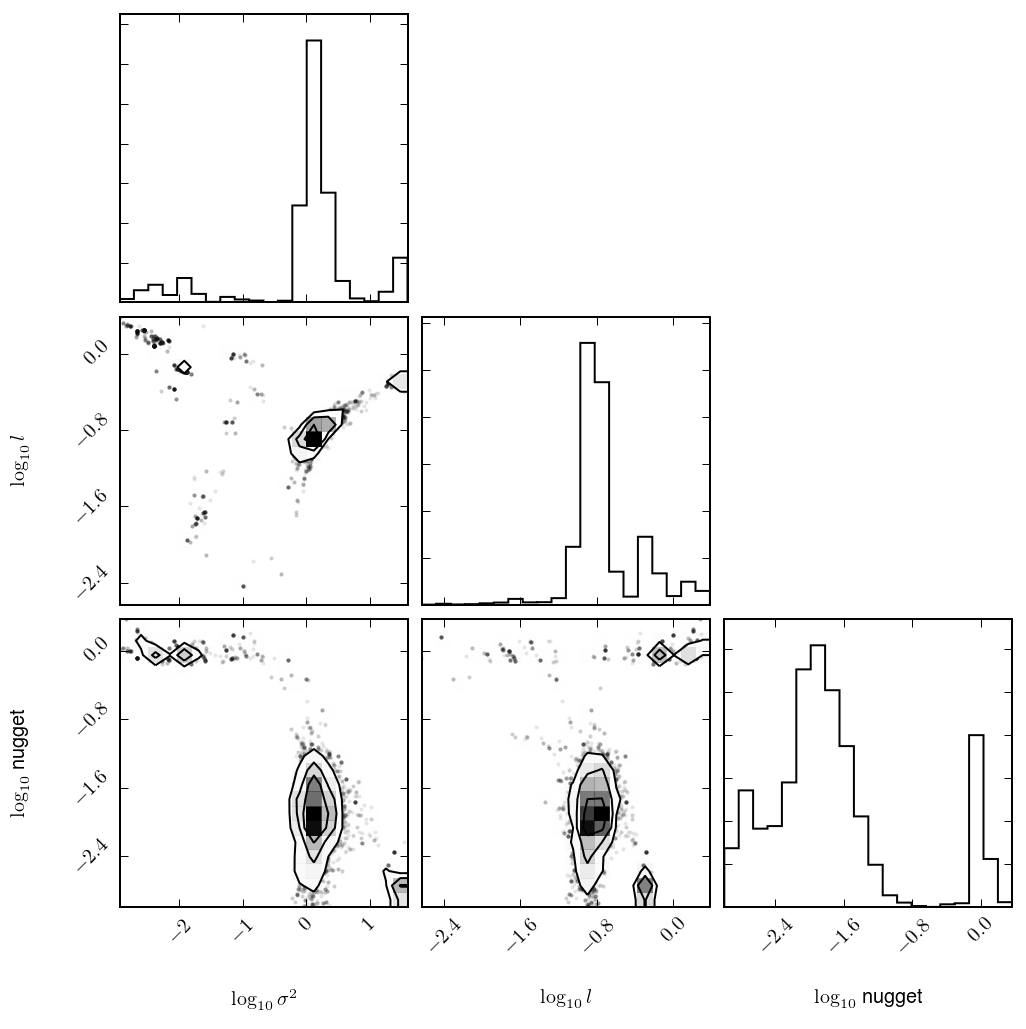

In [467]:
import corner
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

## Gravitational Wave Example